# heat diffusion, impulse response function and transfer function

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.special import jv, jvp, jn_zeros, iv, erfc

import matplotlib.pyplot as plt

---

## disc

### impulse response function

In [2]:
def compute_response_disc(a, k, Tb, r, t, n):
    """ Compute the step response of a disc to temperature at the boundary
    Parameters
    ----------
    a: float
        disc radius
    k: float
        diffusivity coefficient
    Tb: float
        temperature step amplitude
    r: np.array
        radius where to compute the solution
    t: np.array
        time where to compute the solution
    n: int
        number of bessel functions to consider
    """

    ds = xr.Dataset(
        None,
        coords=dict(r=r, mode=np.arange(1,n+1), time=t)
    )
    
    # start building up solution
    ds["zeros"] = ("mode", jn_zeros(0, n))
    ds["lambda"] = ds["zeros"]/a
    ds["I0p"] = jvp(0, a * ds["lambda"])
    ds["Tn"] = 2/a/ds["lambda"]/ds["I0p"]
    
    ds["T_transient"] = Tb * (
        (
            ds["Tn"] 
            * jv(0, ds["lambda"]*ds["r"])
            * np.exp(-k * ds["lambda"]**2 * ds["time"])
        ).sum("mode")
    )
    ds["T"] = Tb + ds["T_transient"]
    
    ds["dT/dt"] = ds["T"].differentiate("time")

    return ds

In [12]:
a = 1 # disc radius
k = 1 # diffusion coefficient
Tb = 1 # step amplitude

r = np.linspace(0, a, 100)
T = a**2/k
t = np.arange(T/200,2*T,T/100)

ds10 = compute_response_disc(a, k, Tb, r, t, 10)
ds5 = compute_response_disc(a, k, Tb, r, t, 5)
ds2 = compute_response_disc(a, k, Tb, r, t, 2)
ds1 = compute_response_disc(a, k, Tb, r, t, 1)

Text(0.5, 1.0, 'impulse response function at center of disc')

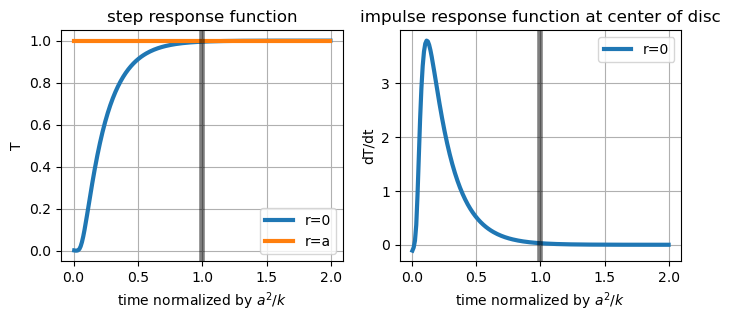

In [13]:
ds = ds10

fig, axes = plt.subplots(1,2, figsize=(8,3))
ax = axes[0]
ds["T"].sel(r=0).plot(ax=ax, lw=3, label="r=0")
ds["T"].sel(r=a, method='nearest').plot(ax=ax, lw=3, label="r=a")
ax.axvline(T, color="k", alpha=0.5, lw=4)
ax.legend()
ax.grid()
ax.set_xlabel(r"time normalized by $a^2/k$")
ax.set_title("step response function")

ax = axes[1]
ds["dT/dt"].sel(r=0).plot(ax=ax, lw=3, label="r=0")
ax.axvline(T, color="k", alpha=0.5, lw=4)
ax.legend()
ax.grid()
ax.set_xlabel(r"time normalized by $a^2/k$")
ax.set_title("impulse response function at center of disc")

### sensitivity to the number of bessels added

Text(0.5, 1.0, 'impulse response function at center of disc')

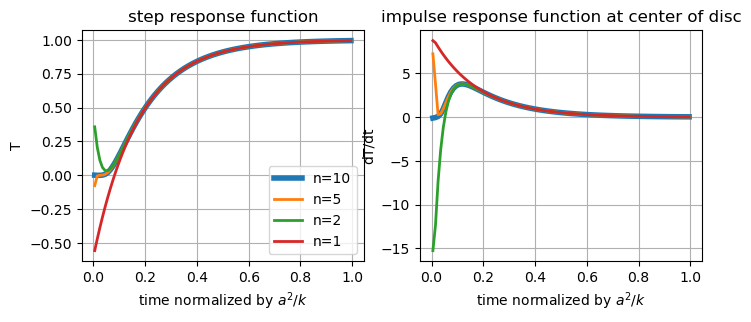

In [5]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
ax = axes[0]
ds10["T"].sel(r=0).plot(ax=ax, lw=4, label="n=10")
ds5["T"].sel(r=0).plot(ax=ax, lw=2, label="n=5")
ds2["T"].sel(r=0).plot(ax=ax, lw=2, label="n=2")
ds1["T"].sel(r=0).plot(ax=ax, lw=2, label="n=1")
ax.legend()
ax.grid()
ax.set_xlabel(r"time normalized by $a^2/k$")
ax.set_title("step response function")

ax = axes[1]
ds10["dT/dt"].sel(r=0).plot(ax=ax, lw=4, label="n=10")
ds5["dT/dt"].sel(r=0).plot(ax=ax, lw=2, label="n=5")
ds2["dT/dt"].sel(r=0).plot(ax=ax, lw=2, label="n=2")
ds1["dT/dt"].sel(r=0).plot(ax=ax, lw=2, label="n=2")
#ax.legend()
ax.grid()
ax.set_xlabel(r"time normalized by $a^2/k$")
ax.set_title("impulse response function at center of disc")

In [6]:
a = 0.05
t = 3600
k = a**2/t * 0.1
k

6.944444444444447e-08

### transfer function

In [36]:
def compute_transfer_function(a, k, r, omega):
    """ Compute the step response of a disc to temperature at the boundary
    Parameters
    ----------
    a: float
        disc radius
    k: float
        diffusivity coefficient
    r: np.array
        radius where to compute the solution
    omega: np.array
        frequencies where to compute the transfer function
    """

    ds = xr.Dataset(
        None,
        coords=dict(r=r, omega=omega)
    )
    ds["omega_rad"] = ds["omega"]*2*np.pi
    
    kt = np.sqrt(1j*ds["omega_rad"]/k)
    ds["H"] = iv(0, ds["r"]* kt)/iv(0, a* kt)
    ds["H_angle"] = (ds["H"].dims, np.angle(ds["H"]))

    return ds


# does not seem to work -- slow convergence?
def compute_transfer_function_series(a, k, r, omega, n):
    """ Compute the step response of a disc to temperature at the boundary
    Parameters
    ----------
    a: float
        disc radius
    k: float
        diffusivity coefficient
    r: np.array
        radius where to compute the solution
    omega: np.array
        frequencies where to compute the transfer function
    n: int
        number of bessel functions to consider
    """

    ds = xr.Dataset(
        None,
        coords=dict(r=r, mode=np.arange(1,n+1), omega=omega)
    )
    ds["omega_rad"] = ds["omega"]*2*np.pi

    
    # start building up solution
    ds["zeros"] = ("mode", jn_zeros(0, n))
    ds["lambda"] = ds["zeros"]/a
    ds["I0p"] = jvp(0, a * ds["lambda"])
    ds["Tn"] = -2*k*ds["lambda"]/a/ds["I0p"]
    
    ds["H"] = (
        ds["Tn"]
        * jv(0, ds["lambda"]*ds["r"])
        / (1j*ds["omega_rad"] + k * ds["lambda"]**2)
    ).sum("mode")
    ds["H_angle"] = (ds["H"].dims, np.angle(ds["H"]))

    return ds



In [37]:
a = 1 # disc radius
k = 1 # diffusion coefficient

r = np.linspace(0, a, 100)
T = a**2/k
omega = np.logspace(np.log10(1/T)-3,np.log10(1/T)+3,100)

ds1_s = compute_transfer_function_series(a, k, r, omega, 100)
ds10_s = compute_transfer_function_series(a, k*10, r, omega, 100)

ds1 = compute_transfer_function(a, k, r, omega)
ds10 = compute_transfer_function(a, k*10, r, omega)

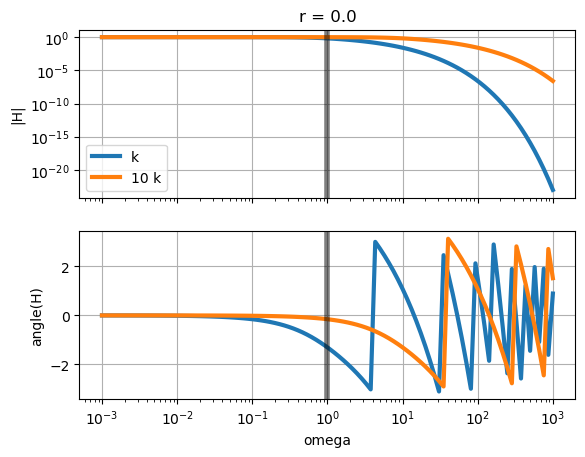

In [38]:
fig, axes = plt.subplots(2,1, sharex=True)
ax=axes[0]
np.abs(ds1["H"].sel(r=0)).rename("|H|").plot(ax=ax, label="k", lw=3)
np.abs(ds10["H"].sel(r=0)).rename("|H|").plot(ax=ax, label="10 k", lw=3)
ax.axvline(1/T, color="k", alpha=0.5, lw=4)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("")
ax.legend()
ax.grid()


ax=axes[1]
ds1["H_angle"].rename("angle(H)").sel(r=0).plot(ax=ax, lw=3)
ds10["H_angle"].rename("angle(H)").sel(r=0).plot(ax=ax, lw=3)
ax.axvline(1/T, color="k", alpha=0.5, lw=4)
ax.set_title("")
#ax.set_xscale("log")
ax.grid()


---

## half-plane

### impulse response function

In [39]:
def compute_response_hplane(k, Tb, z, t):
    """ Compute the step response of a point within an half-plane
    Parameters
    ----------
    k: float
        diffusivity coefficient
    Tb: float
        temperature step amplitude
    z: np.array
        vertical level where solution is computed (negative)
    t: np.array
        time where to compute the solution
    """

    ds = xr.Dataset(
        None,
        coords=dict(z=z, time=t)
    )
        
    #ds["T_transient"] = Tb * (-z) / np.sqrt(4*np.pi*k*ds["time"]**3) * np.exp(-z**2/(4*k*ds["time"]))
    ds["T_transient"] = Tb * erfc( -ds["z"]/np.sqrt(4*k*ds["time"]) )
    ds["T"] = ds["T_transient"]
    
    ds["dT/dt"] = ds["T"].differentiate("time")

    return ds

In [40]:
zr = -1 # location of interest
k = 1 # diffusion coefficient
Tb = 1 # step amplitude

z = np.linspace(zr, 0, 100)
T = zr**2/k
t = np.arange(T/200,T*2,T/100)

ds = compute_response_hplane(k, Tb, z, t)

Text(0.5, 1.0, 'impulse response function at z')

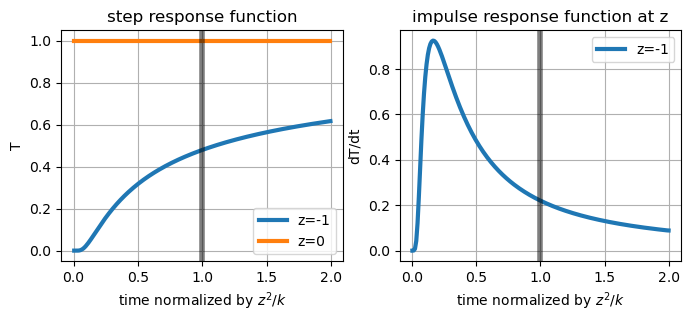

In [41]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
ax = axes[0]
ds["T"].sel(z=zr, method='nearest').plot(ax=ax, lw=3, label=f"z={zr}")
ds["T"].sel(z=0).plot(ax=ax, lw=3, label="z=0")
ax.axvline(T, color="k", alpha=0.5, lw=4)
ax.legend()
ax.grid()
ax.set_xlabel(r"time normalized by $z^2/k$")
ax.set_title("step response function")

ax = axes[1]
ds["dT/dt"].sel(z=zr).plot(ax=ax, lw=3, label=f"z={zr}")
ax.axvline(T, color="k", alpha=0.5, lw=4)
ax.legend()
ax.grid()
ax.set_xlabel(r"time normalized by $z^2/k$")
ax.set_title("impulse response function at z")

### transfer function

In [42]:
def compute_transfer_function_hplane(k, z, omega):
    """ Compute the step response of a disc to temperature at the boundary
    Parameters
    ----------
    z: float
        disc radius
    k: float
        diffusivity coefficient
    r: np.array
        radius where to compute the solution
    omega: np.array
        frequencies where to compute the transfer function
    """

    ds = xr.Dataset(
        None,
        coords=dict(z=z, omega=omega)
    )
    ds["omega_rad"] = ds["omega"]*2*np.pi
    
    kt = np.sqrt(1j*ds["omega_rad"]/k)
    ds["H"] = np.exp(kt*ds["z"])
    ds["H_angle"] = (ds["H"].dims, np.angle(ds["H"]))

    return ds

In [43]:
z = -1 # disc radius
k = 1 # diffusion coefficient

T = z**2/k
omega = np.logspace(np.log10(1/T)-3,np.log10(1/T)+3,100)

ds1 = compute_transfer_function_hplane(k, z, omega)
ds10 = compute_transfer_function_hplane(k*10, z, omega)

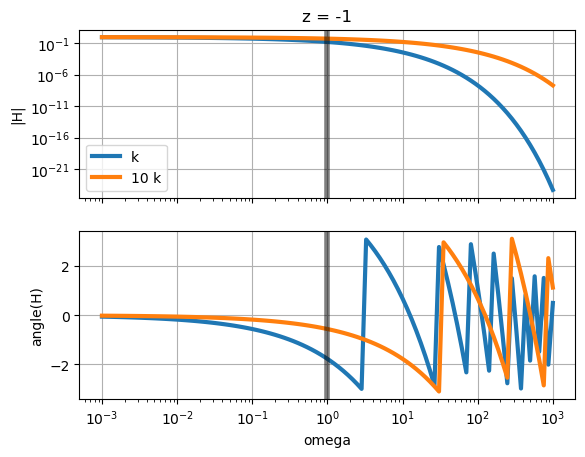

In [44]:
fig, axes = plt.subplots(2,1, sharex=True)
ax=axes[0]
np.abs(ds1["H"]).rename("|H|").plot(ax=ax, label="k", lw=3)
np.abs(ds10["H"]).rename("|H|").plot(ax=ax, label="10 k", lw=3)
ax.axvline(1/T, color="k", alpha=0.5, lw=4)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("")
ax.legend()
ax.grid()

ax=axes[1]
ds1["H_angle"].rename("angle(H)").plot(ax=ax, lw=3)
ds10["H_angle"].rename("angle(H)").plot(ax=ax, lw=3)
ax.axvline(1/T, color="k", alpha=0.5, lw=4)
ax.set_title("")
ax.grid()
#ax.set_xscale("log")